# Explorative time series analysis on ~270 days of Fitbit data

I wanted to analyse my fitbit data for a couple of years now, I was especially curious to see if my activity levels impact my resting heart beat rate (as is claimed, e.g, here: https://www.polar.com/blog/resting-heart-rate/). I've had a Fitbit with HR function since it came out, although I wasn't always wearing it (and I wan't always doing sports!). So, I was ready to see next to know effects, my primary goal was to have fun with time series analysis.

The analysis aims to investigate the following alternative hypothesis: *the more active I am, the lower my resting heart rate should become*. I also look at the following complications in the analysis:
1. How quickly does the effect of higher activity take place?
2. Is there monthly seasonality to my resting heart rate, due to hormonal fluctuations, as is indicated here and in other studies: https://www.nature.com/articles/s41598-017-01433-9

I took several months of my resting heart rate, steps and activity-related data because during that time I had a relatively stable, though rather unplasand lifestype. During the week I was commuting from Oxford to London, during the weekend recoving from the work week. Monday-Friday I walked a total of 2 hours or more (home to train station A, train station B to work, and back) so I had a decent step count. 

Extracting data from Fitbit at this level of detail and scope is not trivial. There used to be nice R packages for that but at the time of writing (Easter breka 2018) they don't work anymore I used Fitbit developer API to do that, to do that there is a detailed tutorial here: https://annofoneblog.wordpress.com/2017/10/19/your-heart-your-calories-your-sleep-your-data-how-to-extract-your-fitbit-data-and-make-graphs-using-r/

This notebook goes through the following stages:
1. Import and format the data
2. Plot the raw data
3. Investigae wholes and anomalies
4. Investigate seasonality and trends
5. Investigate correlations
6. Performs multivariate analysis

As I only extracted 9 months worth of data, with one point per day per variable, there is no way I would have enough for a proper LSTM analysis, perhaps in a few years :) In any case, there is no shame in doing solid statistics in cases where fancy neural nets are like using a bazooka to shoot a sparrow. 

Another thing to keep in mind is the accuracy of the sensors - Fitbit is not a medical grade device, so I cannot be sure the resting heart rate is 100% accurate. Even the step count can be questioned - if you take a ride in a car on a bumpy road, be sure it will add a few hundred steps to you count. Same happens if you knit or crochet. 

I did my best to add comments the cells to explain what is going on.

Useful (and used) Resources:

1. https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
2. http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels
3. https://github.com/nlittlepoole/thermometr
4. https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2

## 1. Import and prepare the data

I have extracted steps, resting heart rate data, minutes of stratified activity per day (sedentary, light, fair, very). All data formates are realtively simple (date - measure) with the exception of heart rate data that has multiple fields and nested structure for every day. Out of privacy considerations I am not adding these files to the repository but if you follow the Fitbit API tutorial, you will get data with the same structure.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import json
from functools import reduce
import statsmodels
import math
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


/anaconda3/envs/scienv3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
minutes_light_active = pd.DataFrame(json.load(open('2016light.json'))['activities-minutesLightlyActive'])
minutes_fairly_active = pd.DataFrame(json.load(open('2016fair.json'))['activities-minutesFairlyActive'])
minutes_very_active = pd.DataFrame(json.load(open('2016very.json'))['activities-minutesVeryActive'])
minutes_sedentary = pd.DataFrame(json.load(open('2016sed.json'))['activities-minutesSedentary'])
steps = pd.DataFrame(json.load(open('2016steps.json'))['activities-steps'])


For the heart rate data we extract the following fields for each date:

1. dateTime
2. restingHeartRate
3. minutesOutofRange
4. minutesFatBurn
5. minutesCardio
6. minutesPeak

In [3]:
heart_rate_list = json.load(open('2016hr.json'))['activities-heart']

final_rows = []
for item in heart_rate_list:
    
    if 'restingHeartRate' in item['value'].keys():
        temp_row = []
        temp_row.append(item['dateTime'])

        temp_row.append(item['value']['restingHeartRate'])
        temp_row.append(item['value']["heartRateZones"][0]['minutes']) # Out of Range
        temp_row.append(item['value']["heartRateZones"][1]['minutes']) # Fat Burn
        temp_row.append(item['value']["heartRateZones"][2]['minutes']) # Cardio
        temp_row.append(item['value']["heartRateZones"][3]['minutes']) # Peak

        final_rows.append(temp_row)
    
heart_rate = pd.DataFrame(final_rows, columns=['dateTime', 'restingHeartRate', "minutesOutofRange", 'minutesFatBurn', 'minutesCardio', 'minutesPeak'])

Merge all dataframes together

In [4]:
df_list = [steps, heart_rate, minutes_sedentary, minutes_light_active, minutes_fairly_active, minutes_very_active]
df_final = reduce(lambda left,right: pd.merge(left,right,on='dateTime'), df_list)

We end up with 10 features but the steps and the resting heart rate are the ones I am most interested in for this analysis, although I bring the other 8 into the picture at the end of the notebook as well.

In [5]:
df_final.columns = ['date', 'steps', 'resting_heart_rate', \
                    'minutes_out_of_range', 'minutes_fat_burn', \
                    'minutes_cardio', 'minutes_peak', 'minutes_sedentary', \
                    'minutes_light_active', 'minutes_fairly_active', 'minutes_very_active']

Convert "date" column from string format to datetime, all other columns to numeric format

In [6]:
df_final[df_final.columns[1:]] = df_final[df_final.columns[1:]].apply(pd.to_numeric)
df_final["date"] = pd.to_datetime(df_final["date"])

df_final.index = df_final["date"]

## 2. Explore the data

Let's plot steps and resting heart rate. See the peak in July? That's when I climbed Ben Nevis!

In [7]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

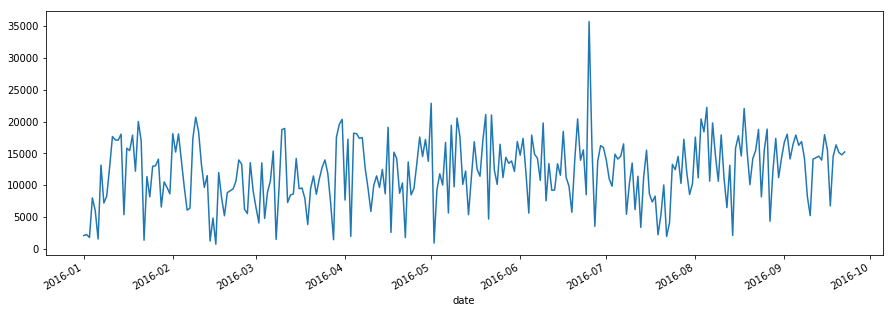

In [8]:
df_final["steps"].plot()

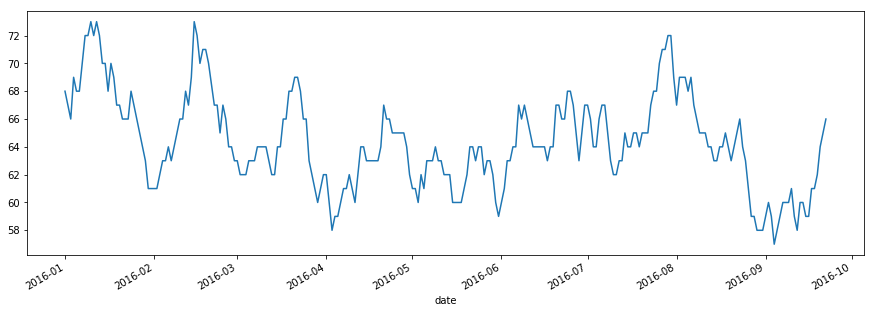

In [9]:
df_final["resting_heart_rate"].plot()

Before we continue with more complex analysis, let's check whether our data is complete, and whether its distribution is normal. 

### Character of value distributions and missing data

In [10]:
for a_column in df_final.columns[1:-2]:

    print (a_column)
    k2, p = stats.normaltest(df_final[a_column])
    alpha = 1e-3
    print("\tp = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("\tNormal distribution\n")
    else:
        print("\tNon-normal distribution\n")
        



steps
	p = 0.122657
	Non-normal distribution

resting_heart_rate
	p = 0.0507582
	Non-normal distribution

minutes_out_of_range
	p = 1.81631e-27
	Normal distribution

minutes_fat_burn
	p = 1.20448e-32
	Normal distribution

minutes_cardio
	p = 1.25817e-19
	Normal distribution

minutes_peak
	p = 6.35985e-58
	Normal distribution

minutes_sedentary
	p = 1.1852e-16
	Normal distribution

minutes_light_active
	p = 3.03884e-05
	Normal distribution



In [11]:
date_set = set(df_final.date[0] + timedelta(x) for x in range((df_final.date[-1] - df_final.date[0]).days))
missing = sorted(date_set - set(df_final.date))

We have one missing record and two of our features are non-normally distributed. Let's fill the missing record with median values from all numeric features. Since it is a single case, I am filling it in almost manual style, not programmatically

In [12]:
missing

[Timestamp('2016-02-21 00:00:00')]

In [13]:
df_final.loc[pd.to_datetime("2016-02-21")] = df_final.median()
df_final.date.loc[pd.to_datetime("2016-02-21")] = pd.to_datetime("2016-02-21")

df_final.sort_index(inplace=True)

/anaconda3/envs/scienv3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Let's look at a few value distributions over days of the week and months

In [14]:
df_final["DayoftheWeek"] = df_final["date"].dt.dayofweek

df_final["month"] = df_final["date"].dt.month

grouped_dow = pd.DataFrame(df_final.groupby('DayoftheWeek')['steps', 'resting_heart_rate', 'minutes_out_of_range',
       'minutes_fat_burn', 'minutes_cardio', 'minutes_peak',
       'minutes_sedentary', 'minutes_light_active', 'minutes_fairly_active',
       'minutes_very_active'].aggregate([np.mean, np.std]))

grouped_m = pd.DataFrame(df_final.groupby('month')['steps', 'resting_heart_rate', 'minutes_out_of_range',
       'minutes_fat_burn', 'minutes_cardio', 'minutes_peak',
       'minutes_sedentary', 'minutes_light_active', 'minutes_fairly_active',
       'minutes_very_active'].aggregate([np.mean, np.std]))

Looks like I had fewer steps per day on average in January-March (no surprise here, cold weather!) and in July, which is probably thanks to my vacation at home where I... take it easy :) 

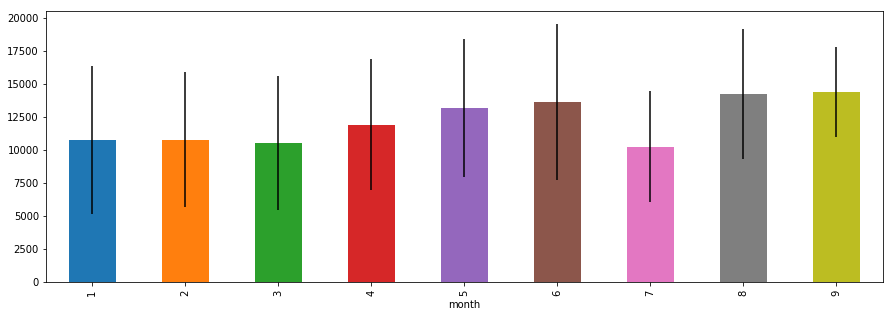

In [15]:
grouped_m['steps']['mean'].plot(kind='bar', yerr=grouped_m['steps']['std'])

Here one can see I used to work from home on Fridays. But from the error bars the differences don't look like they are going to be significantly different. 

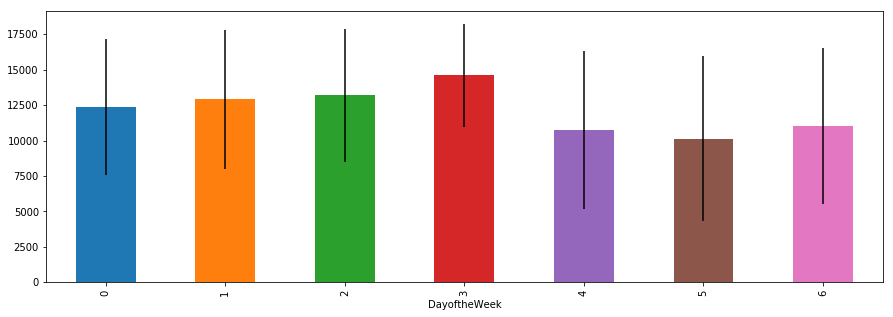

In [16]:
grouped_dow['steps']['mean'].plot(kind='bar', yerr=grouped_dow['steps']['std'])

## 3. Seasonality and anomalies

One big difference between any set of observations and a time sereis data is that the observations are ordered by their occurecne across the time continuum. This allows us to analyse the data for trend and seasonality. The functions below come from https://github.com/nlittlepoole/thermometr and are an implementation for Seasonal Hybrid ESD. There are other implementations of the algo in R (https://github.com/twitter/AnomalyDetection) and python 2, but for python 3 this is the only working one I managed to find.

In [17]:
def seasonal_esd(inputs, a =.025, frequency = 3, start= None, end =None):
    """
    Static method that generates anomolies from the given series
        using S-H-ESD algorithm developed by twitter
    Note:
        Based on frequency, the decompisition trend values can become NULL near the bounds of the series
            this is a stats_model limitation and has been dealt with using an imputation
    Args:
        inputs (np.array[int]): time series of numerical values
        a (float): a confidence level(alpha) for the algorithm to use to determine outliers
        frequency (int): the frequency of season of the data (instances to complete cycle) 
        start (int): the first index in the series to check for anomalies
        end (int): the last index in the series to check for anomalies
    Returns:
        List of tuple pairs (anomoly,index) indicating the anomolies for input series
    """

    outliers = []
    raw = np.copy(inputs) # copy so that you keep inputs immutable        
    data = sm.tsa.seasonal_decompose(raw, freq=frequency)  # STL decomposition algorithm from stats_model

    trend = data.trend
    for i in range(len(trend)):
        substitute = trend[i-frequency] if i > frequency else trend[i + frequency] 
        trend[i]  = substitute if np.isnan(trend[i]) else trend[i]
    vals = data.observed - data.trend - data.seasonal  # distance from STL curve for each point in series
    mean = np.nanmean(vals) # mean of the residuals 

    # need to impute NULL residuals to mean
    pairs = []
    for i in range(len(vals)):
        v  = mean if np.isnan(vals[i]) else vals[i]
        pairs.append((v,i))
    return grubbs_test(inputs, pairs, start,end,a)

def grubbs_test( inputs,errs, start=None,end=None, a = .025):
    """
    Static method that finds anomalies in a sample of normally distributed random variables

    Note:
      An assumption is made that the input data is normal. Grubb's test uses the chi squared 
      distribution and n degrees of freedom to account for small sample sizes

    Args:
        inputs (np.array[int]): time series of numerical values
        start (int): the first index in the series to check for anomalies
        end (int): the last index in the series to check for anomalies
        a (float): a confidence level(alpha) for the algorithm to use to determine outliers
    """
    outliers = []
    vals = errs
    start = 0 if start is None else start
    end = len(vals) -1  if end is None else end
    check = True

    # run grubbs test until the furthest remaining point fails
    while check == True:
        g = 0
        val = 0
        n = len(vals)
        index = 0
        ind = 0
        series  = [ x[0] for x in vals]
        series = np.array(series)
        u = np.nanmean(series)
        s = np.nanstd(series)
        # find residual with largest z value, or distance from mean
        for j in range(len(vals)):
            if j >= start and j <= end:
                v = vals[j][0]
                k = vals[j][1]
                val = v if abs( (u - v )/s)> g else val
                index = int(j) if abs( (u - v) /s)> g else index
                ind = k if abs( (u - v) /s)> g else ind
                g = abs( (u - v) /s) if abs( (u - v) /s)> g else g

        # generate critical value for grubb's test
        critical = ( (n -1) /math.sqrt(n))*math.sqrt(math.pow(scipy.stats.t.ppf(a/(2*n), n -2),2)/ (n -2 + math.pow(scipy.stats.t.ppf(a/(2*n),n-2),2)  )   )
        if g > critical:
            outliers.append((inputs[ind],ind, 1 - critical/g))
        else:
            check = False
        # remove value for next iteration of the test by imputing to new mean
        vals[index] = (u*n - vals[index])/ (n-1)
    return outliers


def derivative(y):
    """
    Returns deriviative of series y

    Args:
        y (np.array[float]): series of values
    Returns
        np.array[float] of changes between values 
    """
    dx = 0.001
    dy = np.diff(y)/dx
    return np.multiply(dy,.001)

def seasonality(y):
    """
    Generates the frequency of a timeseries
    Notes:
       computes frequency by checking average number of times
       for the derivative to change sign 3 times
    Args:
        y (np.array[float]): series of values
    Returns
        int representing frequency 
    """
    vals = derivative(y)
    sign = 1 if vals[0] >=0 else -1
    changes = 0
    count = 0
    counts = [] 
    for val in vals:
        count+=1
        if val * sign < 0:
            sign = -1 if sign >=0 else 1
            changes +=1
            if changes ==3:
                changes =0
                counts.append(count)
                count = 0
    try:
        return int(np.nanmean(np.array(counts[1:]) ) ) 
    except Exception as e:
        print (e)
        return 3



### Seasonality analysis

Seasonality analysis suggests that my steps and my heart rate cycles have 4 and 10 days frequency respectively, but I'm a bit sceptical... Let's see how trends and residuals behave at the automatically extracted seasonality and at slightly more logical 7 days cycle for steps and 28 days cycle for heart rate

In [18]:
seasonality(df_final.resting_heart_rate)

10

In [19]:
seasonality(df_final.steps)

4

Heart rate seasonal decomposition with 10 days cycle

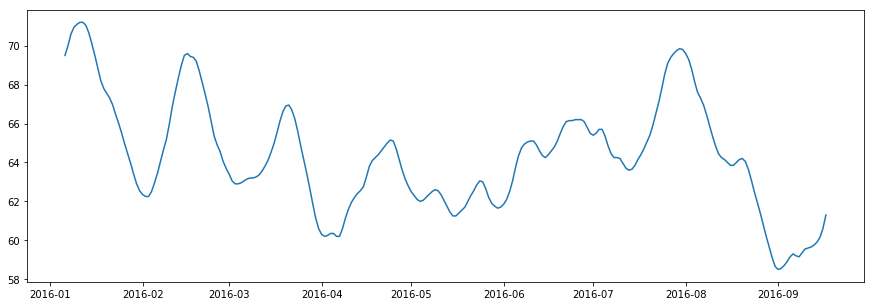

In [20]:
decomposition = seasonal_decompose(df_final.resting_heart_rate, freq=seasonality(df_final.resting_heart_rate))

trend_rhr = decomposition.trend
seasonal_rhr = decomposition.seasonal
residual_rhr = decomposition.resid

plt.plot(trend_rhr, label='Trend')

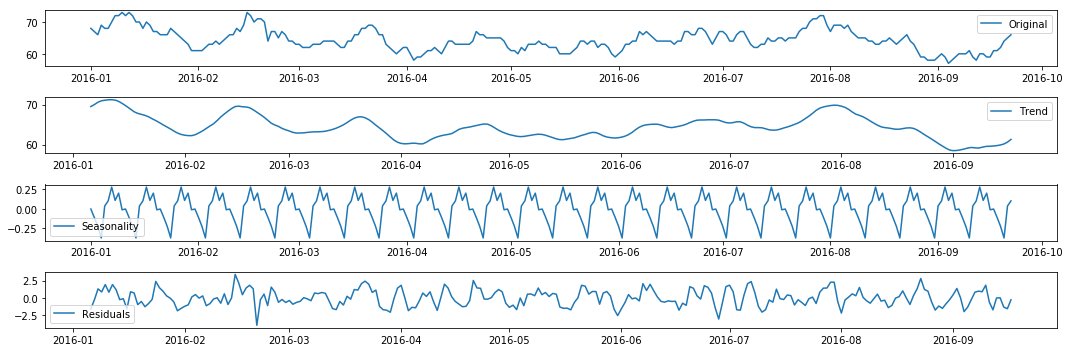

In [21]:
plt.subplot(411)
plt.plot(df_final.resting_heart_rate, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_rhr, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_rhr,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_rhr, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Heart rate seasonal decomposition with 28 days cycle

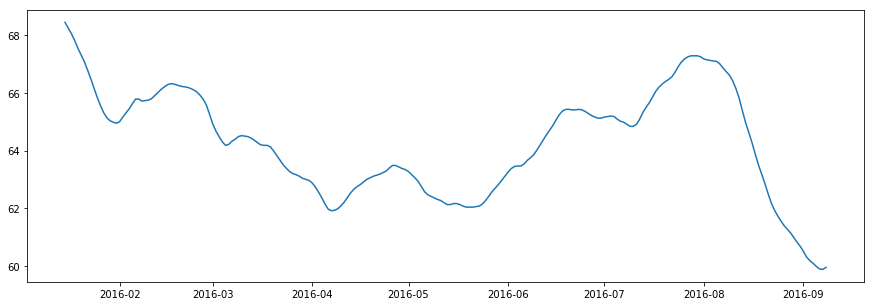

In [22]:
decomposition = seasonal_decompose(df_final.resting_heart_rate, freq=28)

trend_rhr = decomposition.trend
seasonal_rhr = decomposition.seasonal
residual_rhr = decomposition.resid

plt.plot(trend_rhr, label='Trend')

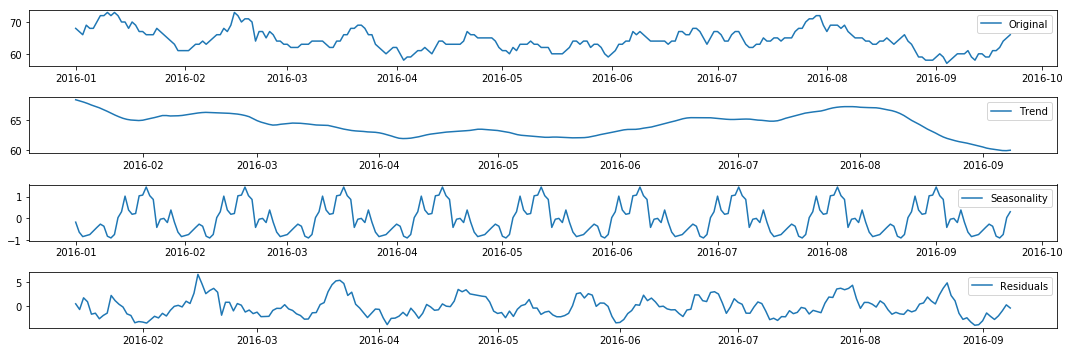

In [23]:
plt.subplot(411)
plt.plot(df_final.resting_heart_rate, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_rhr, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_rhr,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_rhr, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Step seasonal decomposition with 4 days cycle

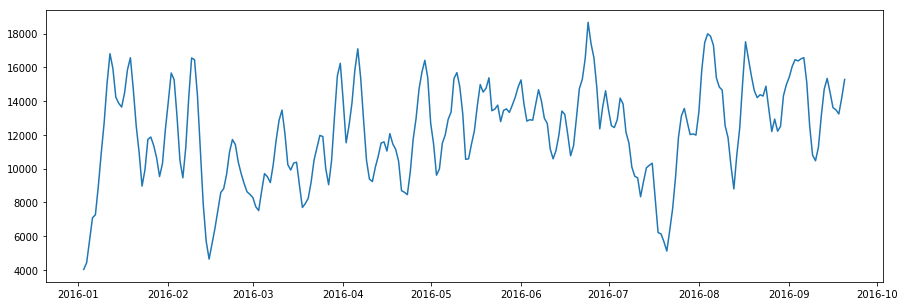

In [24]:
decomposition = seasonal_decompose(df_final.steps, freq=seasonality(df_final.steps))

trend_steps = decomposition.trend
seasonal_steps = decomposition.seasonal
residual_steps = decomposition.resid

plt.plot(trend_steps, label='Trend')

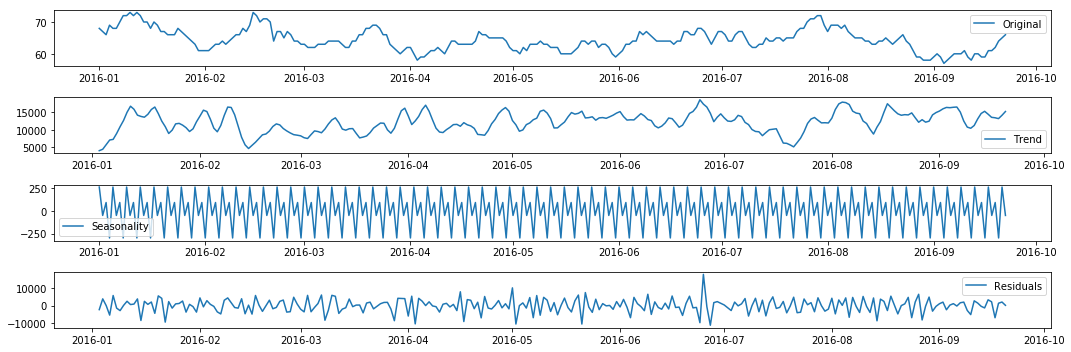

In [25]:
plt.subplot(411)
plt.plot(df_final.resting_heart_rate, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_steps, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_steps,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_steps, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Step seasonal decomposition with 20 days cycle

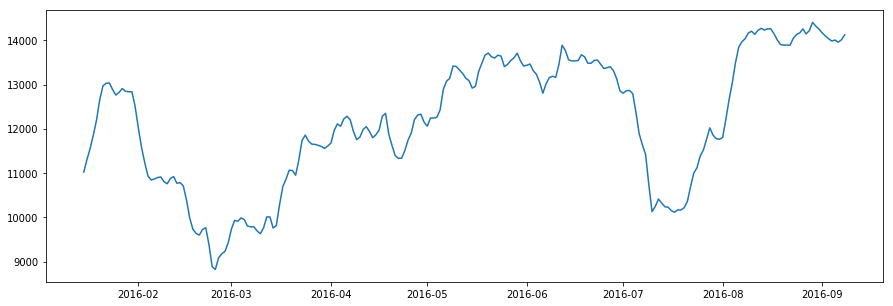

In [26]:
decomposition = seasonal_decompose(df_final.steps, freq=28)

trend_steps = decomposition.trend
seasonal_steps = decomposition.seasonal
residual_steps = decomposition.resid
plt.plot(trend_steps, label='Trend')

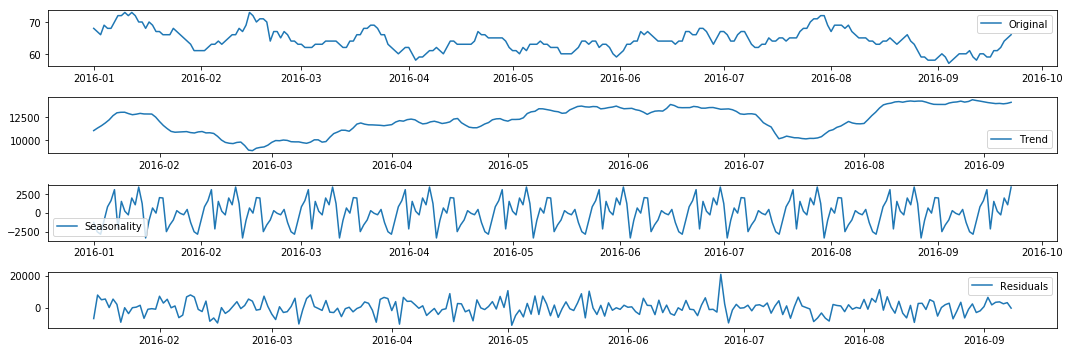

In [27]:
plt.subplot(411)
plt.plot(df_final.resting_heart_rate, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_steps, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_steps,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_steps, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Anomaly detection

Personally, I like the 28-day frequency results more. Let's see if we have any outliers in the steps and heart rate data. Looks like the Ben Nevis hike is the only outlier and as it is not due to a record error, I will leave it in the dataset

In [28]:
seasonal_esd(df_final.steps, a =.025, frequency = 28, start= None, end =None)

[(35677.0, 176, 0.1506420641881011)]

In [29]:
seasonal_esd(df_final.resting_heart_rate, a =.025, frequency = 28, start= None, end =None)

[]

### Trend analysis

Ok, so ultimately I want to run multivariate analysis to see whether any of the variables affect my resting heart rate. But first, let's check if we have trends in our data, because if there are, the analysis will be a bit more complex.

Is there a trend is any of the features? According to the adfuller test (https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test) - No, which makes things quite a bit easier

In [30]:
for a_column in df_final.columns[1:-2]:
    print (a_column, "p_value:", round(sm.tsa.stattools.adfuller(df_final[a_column])[1], 4))


steps p_value: 0.0
resting_heart_rate p_value: 0.0091
minutes_out_of_range p_value: 0.0
minutes_fat_burn p_value: 0.0
minutes_cardio p_value: 0.0031
minutes_peak p_value: 0.0
minutes_sedentary p_value: 0.0
minutes_light_active p_value: 0.0
minutes_fairly_active p_value: 0.0
minutes_very_active p_value: 0.0002


## Correlation and Multivariate analysis

### Cross-correlation analysis

"minutes_very_active" correlate highly with number of steps per day (0.8), there are a few more decent correlations (above 0.3 or under -0.3) but none of those correlations are in the heart rate column, top value is with "minutes_fat_burn" (0.24). 

In [31]:
corr = df_final[df_final.columns[:-2]].corr()

In [32]:
corr

,steps,resting_heart_rate,minutes_out_of_range,minutes_fat_burn,minutes_cardio,minutes_peak,minutes_sedentary,minutes_light_active,minutes_fairly_active,minutes_very_active
steps,1.000000,-0.093658,-0.086578,0.590093,0.414382,0.137540,-0.150267,0.265779,0.484928,0.809240
resting_heart_rate,-0.093658,1.000000,-0.110423,0.245870,0.044476,0.075052,-0.005522,0.035413,0.041559,-0.144761
minutes_out_of_range,-0.086578,-0.110423,1.000000,-0.283102,-0.135791,0.000695,-0.621213,0.069935,-0.186250,-0.038467
minutes_fat_burn,0.590093,0.245870,-0.283102,1.000000,0.344120,0.073880,-0.154733,0.378418,0.522880,0.413867
minutes_cardio,0.414382,0.044476,-0.135791,0.344120,1.000000,0.261434,-0.023649,0.028669,0.098873,0.502273
minutes_peak,0.137540,0.075052,0.000695,0.073880,0.261434,1.000000,-0.092435,0.069397,0.006212,0.159454
minutes_sedentary,-0.150267,-0.005522,-0.621213,-0.154733,-0.023649,-0.092435,1.000000,-0.205778,-0.086379,-0.140984
minutes_light_active,0.265779,0.035413,0.069935,0.378418,0.028669,0.069397,-0.205778,1.000000,0.299361,-0.146860
minutes_fairly_active,0.484928,0.041559,-0.186250,0.522880,0.098873,0.006212,-0.086379,0.299361,1.000000,0.067415
minutes_very_active,0.809240,-0.144761,-0.038467,0.413867,0.502273,0.159454,-0.140984,-0.146860,0.067415,1.000000


Same data but as a heat map

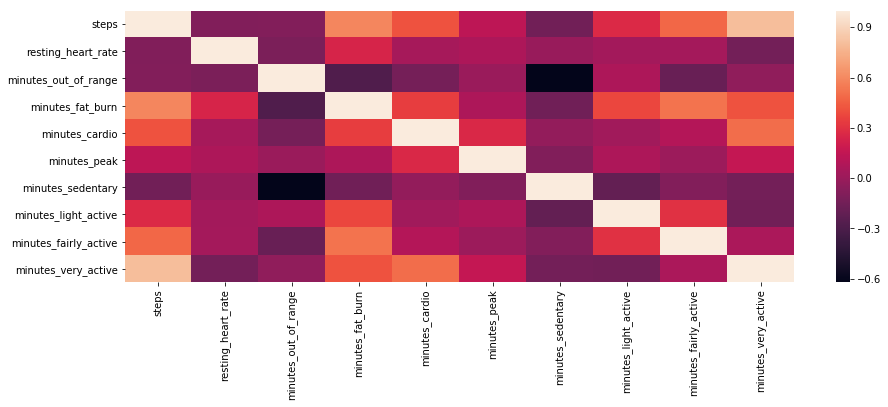

In [33]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

The question with heart rate however is - we cannot expect activity to take immediate effect, no? Let's perform correlation analysis on the residuals (with seasonality taken out) between heart rate and steps, and heart rate and minutes fat burn, but we shift the independent value for 0 to 7 days ahead with each iteration.

In [34]:
residual_minutes_fat_burn = seasonal_decompose(df_final.minutes_fat_burn, freq=28).resid

In [35]:
for i in range(8):
    corr_coeff = np.corrcoef(np.array(residual_steps)[14:-14-i], np.array(residual_rhr)[14+i:-14])
    print (i, corr_coeff[1,0])

0 -0.00559321251201316
1 -0.020368373545929873
2 -0.06274856400679013
3 -0.12960852678263865
4 -0.15260597047136873
5 -0.01618850479309927
6 -0.028582229780405234
7 -0.040184963459703814


In [36]:
for i in range(8):
    corr_coeff = np.corrcoef(np.array(residual_minutes_fat_burn)[14:-14-i], np.array(residual_rhr)[14+i:-14])
    print (i, corr_coeff[1,0])

0 0.2352413386247744
1 0.251529766296356
2 0.2106299014974335
3 0.1022822418709917
4 0.08107823120405734
5 0.12502105989894255
6 0.06446720919603845
7 -0.023907932865097882


Correlations do become stronger with different shifts (4 days for steps and 1 day for minutes fat burn), but they are not very strong. Moreover, this analysis does not take into consideration sequences of very active or not active days. 

## Multivariate Time-Series analysis with ARIMAX

The last thing I want to try here is multivariable TS analysis, appplying ARIMAX model on raw data (ARIMA takes care of seasonality). Here I use heart rate as the dependent variable and all other variables as independent ones. I take a differenced time-series with a shift for the independent variables and a differenced time-series for the heart rate data. 

In [37]:
exog_variables = pd.DataFrame()
exog_variables['rhr_diff']=df_final.resting_heart_rate.diff()
exog_variables['steps_diff']=df_final.steps.diff().shift()
exog_variables['minutes_fat_burn_diff']=df_final.minutes_fat_burn.diff().shift()
exog_variables['minutes_out_of_range_diff']=df_final.minutes_out_of_range.diff().shift()
exog_variables['minutes_cardio_diff']=df_final.minutes_cardio.diff().shift()
exog_variables['minutes_peak_diff']=df_final.minutes_peak.diff().shift()
exog_variables['minutes_sedentary_diff']=df_final.minutes_sedentary.diff().shift()
exog_variables['minutes_light_active_diff']=df_final.minutes_light_active.diff().shift()
exog_variables['minutes_fairly_active_diff']=df_final.minutes_fairly_active.diff().shift()
exog_variables['minutes_very_active_diff']=df_final.minutes_very_active.diff().shift()

exog_variables.dropna(inplace=True)

rhr_model = sm.tsa.ARIMA(endog=exog_variables.rhr_diff,exog=exog_variables[exog_variables.columns[1:]] ,order=[1,1,0])
rhr_results = rhr_model.fit()
print(rhr_results.summary())

/anaconda3/envs/scienv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:             D.rhr_diff   No. Observations:                  263
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -480.768
Method:                       css-mle   S.D. of innovations              1.505
Date:                Sun, 01 Apr 2018   AIC                            985.537
Time:                        15:35:32   BIC                           1028.402
Sample:                    01-04-2016   HQIC                          1002.763
                         - 09-22-2016                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0079      0.065     -0.123      0.902      -0.135       0.119
steps_diff                 -4.611e-05   5.43e-05     -0.849      0.397      -0.000 

/anaconda3/envs/scienv3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/envs/scienv3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
np.corrcoef(np.array(exog_variables['rhr_diff']), np.array(exog_variables['minutes_cardio_diff']))

array([[1.        , 0.22645069],
       [0.22645069, 1.        ]])

So, the only thing I can say at this moment is that minutes I spend doing cardio (relatively high heart rate) affect my resting heart rate. If we look at the actual correlation (which cannot be directly compared to what is happening in ARIMAX), it is positive and below 0.3, so I remian sceptical. As often, more research (and data) needed!